The section below is for image captioning. We create captions for each image in the Chinese Traffic Sign Dataset using the pre-trained "Show and Tell" model from TensorFlow Hub.

In [1]:
!pip install timm
!pip install transformers

In [2]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import random
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
# import timm
# TensorFlow instead of PyTorch
import tensorflow as tf
import tensorflow_hub as hub
from transformers import TFDistilBertModel, DistilBertConfig, DistilBertTokenizer

ModuleNotFoundError: No module named 'cv2'

In [ ]:
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# Define the paths to the image folder and caption file
image_path = "/content/drive/My Drive/CSCI 1470 Final Project/images_new"
caption_file = "/content/drive/My Drive/CSCI 1470 Final Project/captions.txt"

# Read the captions from the file into a Pandas DataFrame
with open(caption_file, "r") as f:
    lines = f.readlines()
captions = []
for i in range(0, len(lines), 2):
    image_name, caption = lines[i].strip().split(',')
    filepath = image_name
    captions.append((filepath, caption))
df = pd.DataFrame(captions, columns=["image", "caption"])

# Assign unique IDs to each image
df["id"] = df.index

# Write the captions to a CSV file
df.to_csv("captions.csv", index=False)

#print(df.head())
print(df['image'])
captions_path = "/content"

Mounted at /content/drive
0             016_0045.png
1       026_1_0041_1_j.png
2             028_0124.png
3           005_1_0085.png
4           005_1_0091.png
               ...        
2994          016_0060.png
2995          016_0048.png
2996        005_1_0088.png
2997        027_1_0008.png
2998        026_0028_j.png
Name: image, Length: 2999, dtype: object


In [ ]:
# configuration class
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 1
    device = tf.device("/GPU:0" if tf.test.is_gpu_available() else "/CPU:0")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

    # For saved model
    export = "/content/drive/My Drive/CSCI 1470 Final Project"

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
# average meter class
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    return optimizer.learning_rate.numpy()

In [ ]:
from transformers.pipelines.pt_utils import KeyPairDataset
class CLIPDataset(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, captions, tokenizer, transforms, batch_size, shuffle=True):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()


    def __getitem__(self, idx):
        # get the filenames in a batch
        file_names = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        captions = self.captions[idx * self.batch_size : (idx+1) * self.batch_size]

        item = {}
        for key, values in self.encoded_captions.items():
          item[key] = []
        item['image'] = []
        item['caption'] = []
        
        for i in range(self.batch_size):
          for key, values in self.encoded_captions.items():
            item[key].append(tf.constant(values[idx*self.batch_size + i]))

          image = cv2.imread(f"{CFG.image_path}/{file_names[i]}")
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = self.transforms(image=image)['image']
          image = tf.constant(image, dtype=tf.float32)
          item['image'].append(image)
          item['caption'].append(captions[i])

        for key, values in self.encoded_captions.items():
          item[key] = tf.stack(item[key])
        item['image'] = tf.stack(item['image'])
        item['caption'] = tf.stack(item['caption'])

        return item

    def __len__(self):
        return len(self.captions) // self.batch_size
      
    def on_epoch_end(self):
        if self.shuffle == True:
          indices = np.arange(len(self.image_filenames))
          np.random.shuffle(indices)
          self.image_filenames = self.image_filenames[indices]
          self.captions = np.array(self.captions)
          self.captions = self.captions[indices]



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
# image encoder class
class ImageEncoder(tf.keras.Model):
  """
  Encode Images into fixed size vector
  """
  def __init__(self, model_name = CFG.model_name, pretrained = CFG.pretrained, trainable = CFG.trainable):
    super().__init__()
    # self.model = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5", trainable=True)
    self.model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling='avg'
    )

  def call(self, x):
    input = tf.keras.backend.variable(x)
    return self.model(input)

In [ ]:
# text encoder class
class TextEncoder(tf.keras.Model):
  def __init__(self, model_name = CFG.text_encoder_model, pretrained = CFG.pretrained, trainable = CFG.trainable):
    super(TextEncoder, self).__init__()
    if pretrained:
      self.model = TFDistilBertModel.from_pretrained(model_name)
    else: 
      self.model = TFDistilBertModel(config = DistilBertConfig())
    
    for layer in self.model.layers:
      layer.trainable = trainable

    # we are using the CLS token hidden representation as the sentence's embedding
    self.target_token_idx = 0

  def call(self, input_ids, attention_mask):
    output = self.model(input_ids=input_ids, attention_mask = attention_mask)
    last_hidden_state = output.last_hidden_state 
    return last_hidden_state[:, self.target_token_idx, :]

In [ ]:
# changed from Pytorch to Tensorflow
import tensorflow as tf

# The purpose of this class is to project the high-dimensional image and text features to a 
# lower-dimensional embedding space where their similarities can be measured using
# a similarity metric such as cosine similarity. The projected embeddings are used to 
# compute the cross-modal similarity score between images and text in our model.

class ProjectionHead(tf.keras.Model):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = tf.keras.layers.Dense(projection_dim)
        self.gelu = tf.keras.layers.Activation('gelu')
        self.fc = tf.keras.layers.Dense(projection_dim)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.layer_norm = tf.keras.layers.LayerNormalization()
    
    def call(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [ ]:
# changed from Pytorch to Tensorflow

class CLIPModel(tf.keras.Model):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def call(self, batch):
        # Getting image and text features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(batch["input_ids"], batch["attention_mask"])

        # Getting image and text embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the loss
        # tf.nn.softmax_cross_entropy_with_logits is used
        logits = tf.matmul(text_embeddings, image_embeddings, transpose_b=True) / self.temperature
        images_similarity = tf.matmul(image_embeddings, image_embeddings, transpose_b=True)
        texts_similarity = tf.matmul(text_embeddings, text_embeddings, transpose_b=True)
        targets = tf.nn.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, axis=-1
        )

        texts_loss = tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=logits, axis=-1)
        images_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(targets), logits=tf.transpose(logits), axis=-1)

        loss = (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return tf.reduce_mean(loss)

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
        batch_size=CFG.batch_size,
        shuffle=True if mode == "train" else False
    )
    
    return dataset

In [ ]:
# changed from Pytorch to Tensorflow 
@tf.function
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = tf.keras.metrics.Mean()
    losses = []
    batch_num = 0
    print(f"total batch: {len(train_loader)}")
    for batch in train_loader:
        batch_num += 1
        batch = {k: v for k, v in batch.items() if k != "caption"}
        with tf.GradientTape() as tape:
            loss = model(batch)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if step == "batch":
            lr_scheduler.step()

        count = tf.shape(batch["image"])[0]
        loss_meter.update_state(loss, count)
        print(f"Batch: {batch_num}, train_loss: {tf.get_static_value(loss)}")
        losses.append(tf.get_static_value(loss))

    return loss_meter.result().numpy(), losses

def valid_epoch(model, valid_loader):
    loss_meter = tf.keras.metrics.Mean()
    # tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    batch_num = 0
    print(f"total batch: {len(valid_loader)}")
    for batch in valid_loader:
        batch_num += 1
        batch = {k: v for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = tf.shape(batch["image"])[0]
        loss_meter.update(loss, count)
        print(f"Batch: {batch_num}, valid_loss: {tf.get_static_value(loss)}")
        # tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter.result().numpy()

In [ ]:
def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel()

    optimizer = tf.keras.optimizers.Adam(learning_rate=CFG.head_lr)

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', mode="min", patience=CFG.patience, factor=CFG.factor
    )

    step = "epoch"
    best_loss = float('inf')

    tf.config.run_functions_eagerly(True)
    print(f"main: {tf.executing_eagerly()}")

    # for epoch in range(CFG.epochs):
    for epoch in range(1):
        print(f"Epoch: {epoch + 1}")
        train_loss, losses = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        print(f"Epoch train loss: {train_loss}")
        #valid_loss = valid_epoch(model, valid_loader)
        #print(f"Epoch valid loss: {valid_loss}")

        x = [i for i in range(len(losses))]
        plt.plot(x, losses)
        plt.title('Loss per batch')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.show()

        model.save_weights(CFG.export)

        print("Saved Best Model!")

shape
(2400,)
shape
(599,)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


main: True
Epoch: 1
total batch: 75
Batch: 1, train_loss: 7.584460258483887
Batch: 2, train_loss: 4.025073051452637
Batch: 3, train_loss: 3.501366138458252
Batch: 4, train_loss: 3.9987998008728027
Batch: 5, train_loss: 3.4984922409057617
Batch: 6, train_loss: 3.4673824310302734
Batch: 7, train_loss: 3.4663643836975098
Batch: 8, train_loss: 3.465974807739258
Batch: 9, train_loss: 3.4658267498016357
Batch: 10, train_loss: 3.4657673835754395
Batch: 11, train_loss: 3.4657480716705322
Batch: 12, train_loss: 3.465740203857422
Batch: 13, train_loss: 3.4657399654388428
Batch: 14, train_loss: 3.465738534927368
Batch: 15, train_loss: 3.465738534927368
Batch: 16, train_loss: 3.4657363891601562
Batch: 17, train_loss: 3.465736150741577
Batch: 18, train_loss: 3.4657363891601562
Batch: 19, train_loss: 3.4657363891601562
Batch: 20, train_loss: 3.465736150741577
Batch: 21, train_loss: 3.4657363891601562
Batch: 22, train_loss: 3.4657363891601562
Batch: 23, train_loss: 3.4657363891601562
Batch: 24, train

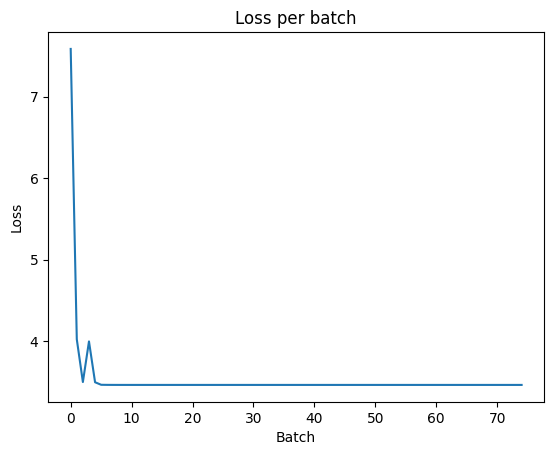

Saved Best Model!


In [ ]:
main()

In [ ]:
def get_image_embeddings(valid_df):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel()
    model.load_weights(CFG.export)
    
    valid_image_embeddings = []
    for batch in tqdm(valid_loader):
        image_features = model.image_encoder(batch["image"])
        image_embeddings = model.image_projection(image_features)
        valid_image_embeddings.append(image_embeddings.numpy())
    return model, np.concatenate(valid_image_embeddings)

In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df)

shape
(599,)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = TFDistilBertModel.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {key: tf.constant(values).to(CFG.device) for key, values in encoded_query.items()}
    text_features = model.text_encoder(batch)
    text_embeddings = model.text_projection(text_features)

    image_embeddings_n = tf.math.l2_normalize(image_embeddings, axis=-1)
    text_embeddings_n = tf.math.l2_normalize(text_embeddings, axis=-1)
    dot_similarity = tf.matmul(text_embeddings_n, image_embeddings_n, transpose_b=True)

    values, indices = tf.math.top_k(tf.squeeze(dot_similarity), k=n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()


In [ ]:
from transformers import DistilBertModel, DistilBertTokenizerFast


def find_matches(model, image_embeddings, query, image_filenames, n=4):
    tokenizer = DistilBertTokenizerFast.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query], padding=True, truncation=True, max_length=CFG.max_length, return_tensors='tf')
    batch = {key: tf.cast(tf.constant(values), dtype=tf.int32) for key, values in encoded_query.items()}
    attention_mask = batch['attention_mask']
    del batch['attention_mask']
    text_features = model.text_encoder(batch, attention_mask=attention_mask)
    text_embeddings = model.text_projection(text_features)

    image_embeddings_n = tf.math.l2_normalize(image_embeddings, axis=-1)
    text_embeddings_n = tf.math.l2_normalize(text_embeddings, axis=-1)
    dot_similarity = tf.matmul(text_embeddings_n, image_embeddings_n, transpose_b=True)

    values, indices = tf.math.top_k(tf.squeeze(dot_similarity), k=n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    fig, axes = plt.subplots(2, 2, figsize=(4, 4))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

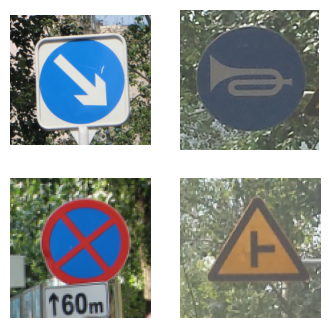

In [ ]:
query = "circle sign"
find_matches(model, 
             image_embeddings,
             query=query,
             image_filenames=valid_df['image'].values,
             n=4)